# Simple Recurrent Neural Network

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

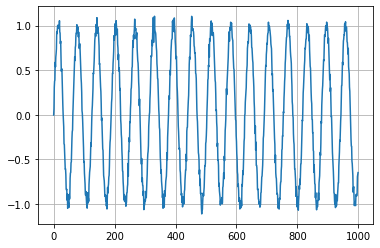

In [68]:
N = 1000

series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.05 

plt.plot(series)
plt.grid()

In [69]:
T = 10

X = []
Y = []

for t in range(len(series)-T):

    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)

N = len(X)


X.shape

(990, 10, 1)

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [71]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)

    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [72]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=2, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, num_layers=2, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [73]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=1000):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses


In [74]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                   
                   
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/1000, Train Loss: 0.5464, Test Loss: 0.5551
Epoch 10/1000, Train Loss: 0.5256, Test Loss: 0.5360
Epoch 15/1000, Train Loss: 0.5144, Test Loss: 0.5244
Epoch 20/1000, Train Loss: 0.5020, Test Loss: 0.5114
Epoch 25/1000, Train Loss: 0.4888, Test Loss: 0.4977
Epoch 30/1000, Train Loss: 0.4749, Test Loss: 0.4833
Epoch 35/1000, Train Loss: 0.4606, Test Loss: 0.4683
Epoch 40/1000, Train Loss: 0.4453, Test Loss: 0.4522
Epoch 45/1000, Train Loss: 0.4276, Test Loss: 0.4333
Epoch 50/1000, Train Loss: 0.4069, Test Loss: 0.4119
Epoch 55/1000, Train Loss: 0.3845, Test Loss: 0.3884
Epoch 60/1000, Train Loss: 0.3597, Test Loss: 0.3627
Epoch 65/1000, Train Loss: 0.3321, Test Loss: 0.3344
Epoch 70/1000, Train Loss: 0.3044, Test Loss: 0.3063
Epoch 75/1000, Train Loss: 0.2752, Test Loss: 0.2759
Epoch 80/1000, Train Loss: 0.2410, Test Loss: 0.2397
Epoch 85/1000, Train Loss: 0.2015, Test Loss: 0.1983
Epoch 90/1000, Train Loss: 0.1604, Test Loss: 0.1575
Epoch 95/1000, Train Loss: 0.1301, Test Loss: 0

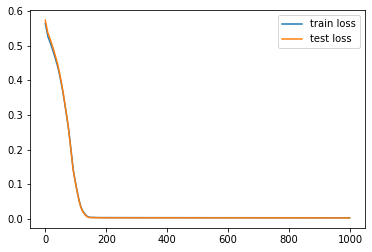

In [75]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [76]:

validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  validation_predictions.append(p[0,0].item())
  
  last_x = torch.cat((last_x[1:], p[0]))

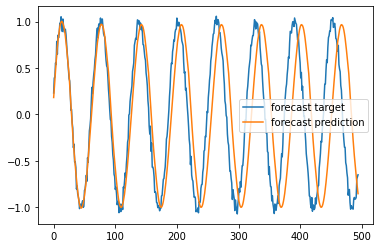

In [77]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()